In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.core.problem import ElementwiseProblem
from scipy.spatial import KDTree
from pymoo.core.mutation import Mutation
from sklearn.cluster import BisectingKMeans
from pymoo.core.sampling import Sampling
from pymoo.core.crossover import Crossover
from scipy.stats import mode

(3635, 50)
(3635, 2)


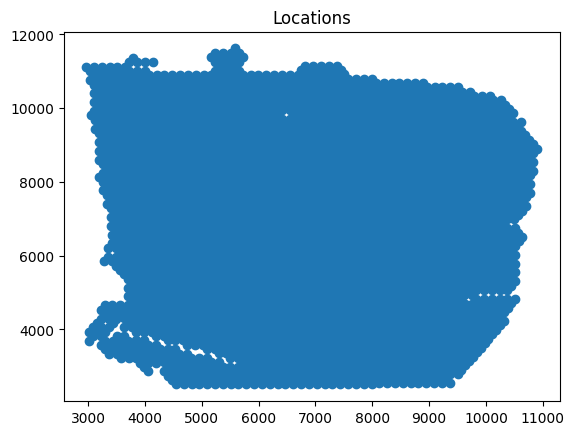

In [2]:
X = np.load('DLPFC_spot_expression.npy')
Z = np.load('DLPFC_spot_location.npy')

print(X.shape)
print(Z.shape)

plt.scatter(Z[:, 0], Z[:, 1])
plt.title("Locations")
plt.show()

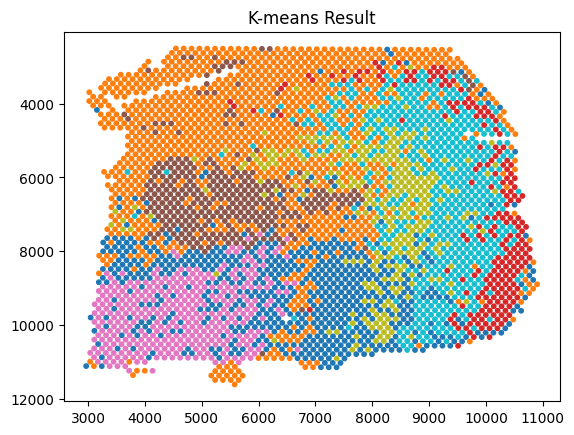

In [3]:
# scale data for simple k means
X_s = StandardScaler().fit_transform(X)
Z_s = StandardScaler().fit_transform(Z)

# combine and weigh columns (change 0.5 for different results)
combined = np.hstack([X_s, Z_s * .5])

# run k means
kmeans = KMeans(n_clusters=7, random_state=42)
labels = kmeans.fit_predict(combined)

# plot result
plt.scatter(Z[:, 0], Z[:, 1], c=labels, cmap="tab10", s=10)
plt.title("K-means Result")
plt.gca().invert_yaxis()
plt.show()

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |      2 |             - |             -
     2 |      400 |      7 |  0.9366547544 |         ideal
     3 |      600 |     10 |  0.4633550182 |         ideal
     4 |      800 |      7 |  0.3631536766 |         ideal
     5 |     1000 |     13 |  0.1403429348 |         ideal
     6 |     1200 |     12 |  0.1116883695 |         ideal
     7 |     1400 |     16 |  0.0867509929 |         ideal
     8 |     1600 |     14 |  0.1656890955 |         ideal
     9 |     1800 |     15 |  0.1873720279 |         ideal
    10 |     2000 |     15 |  0.1242450529 |         ideal
    11 |     2200 |     22 |  0.0795872251 |         ideal
    12 |     2400 |     21 |  0.0383569543 |             f
    13 |     2600 |     21 |  0.0614218653 |         ideal
    14 |     2800 |     23 |  0.0042800023 |         ideal
    15 |     3000 |     34 |  0.0437095756 |         ideal
    16 |     3200 |     25 |  0.0060841459 |         ide

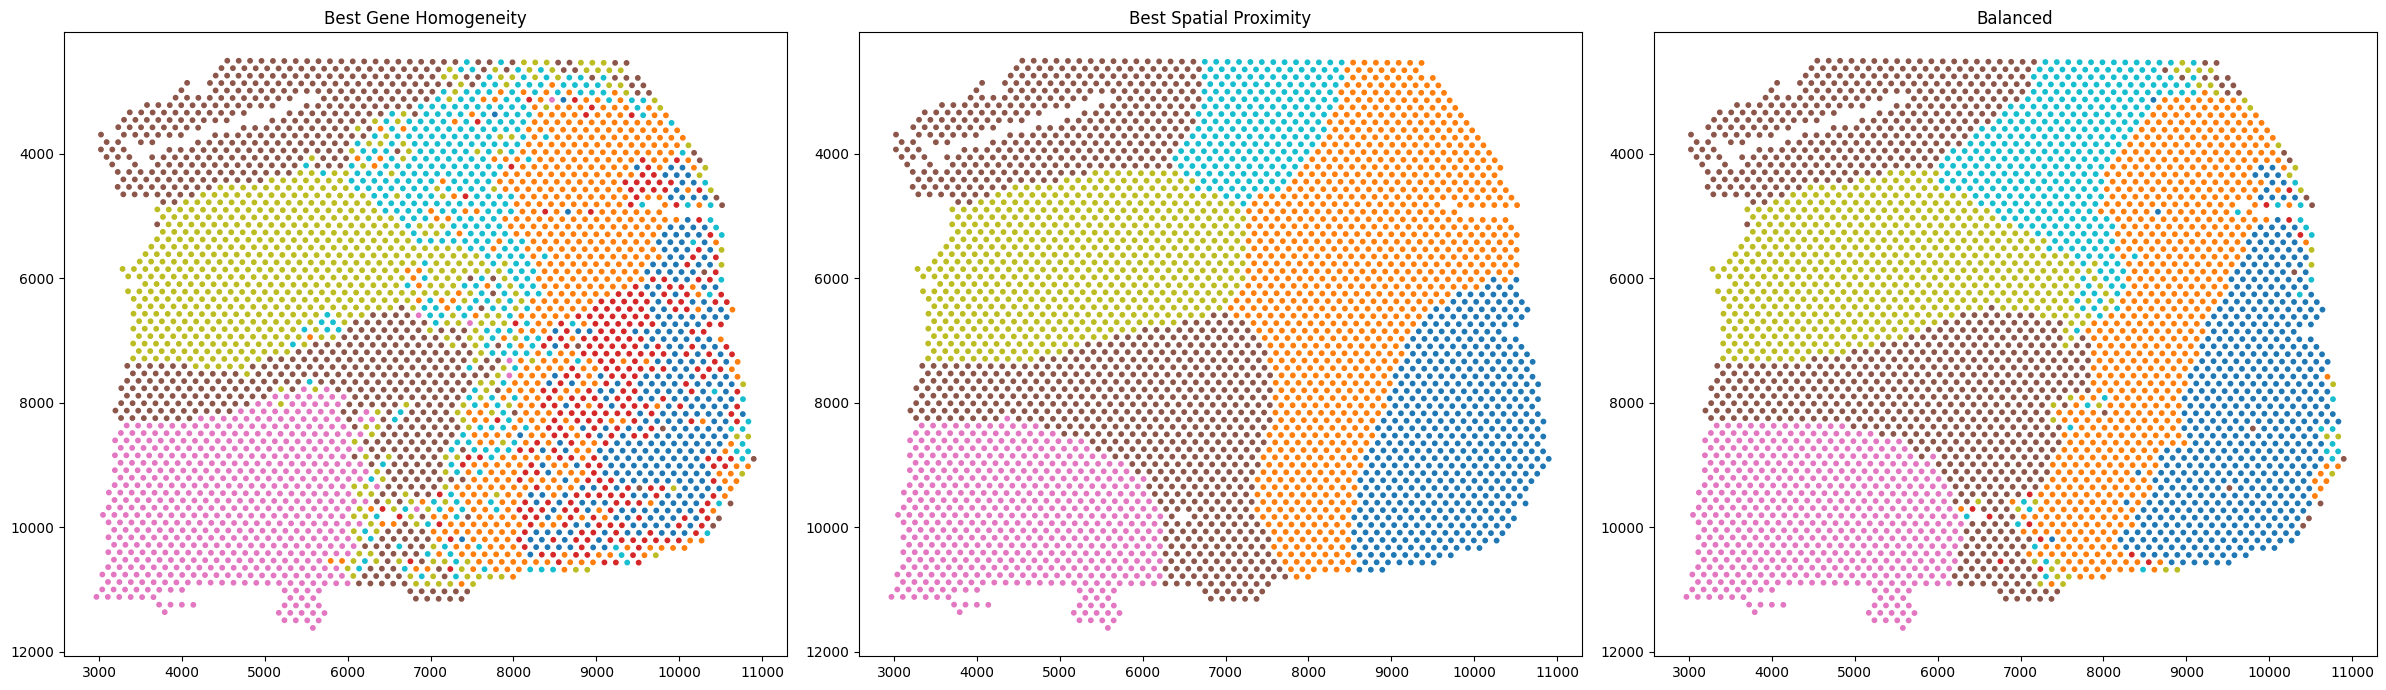

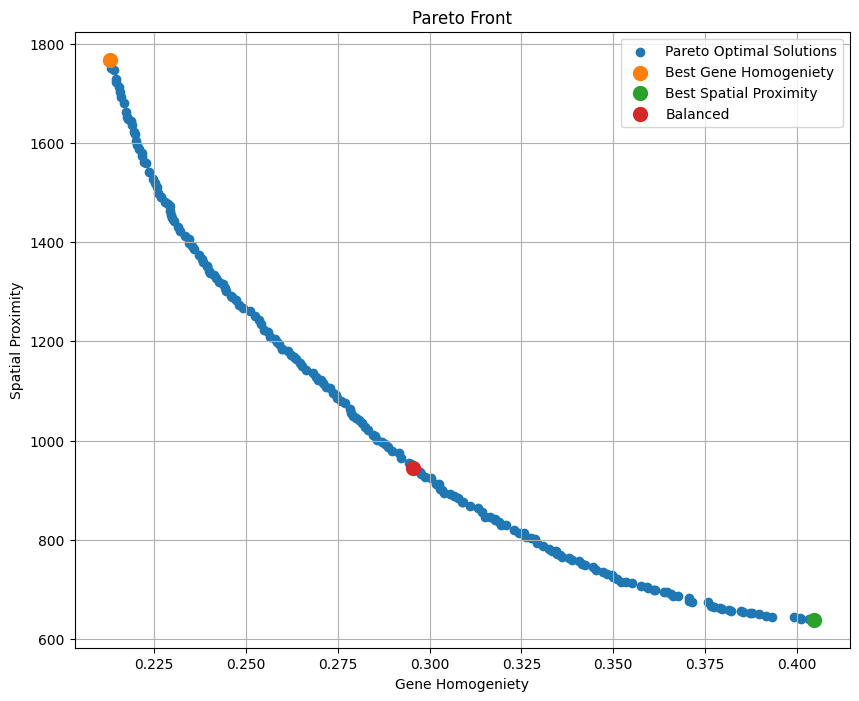

In [4]:
# get 70 neighbors for each point
neighbors = KDTree(Z).query(Z, k=70)[1][:, 1:]

class Problem(ElementwiseProblem):
    def __init__(self):
        # set up pymoo problem
        super().__init__(n_var=len(X), n_obj=2, xu=6, vtype=int)

    def _evaluate(self, x, out):
        # sse of genes in a cluster
        sse = sum(np.sum((X[x==i] - X[x==i].mean(0))**2) for i in range(7) if np.any(x==i))

        # how many borders are with a different cluster
        borders = np.sum(x[neighbors] != x[:, np.newaxis])

        # pymoo output. normalize first
        out["F"] = [sse / np.sum((X - X.mean(0))**2), borders / len(X) * 70]

class Crossover(Crossover):
    def __init__(self):
        super().__init__(2, 2)
    def _do(self, problem, X, **kwargs):
        _, n, nvars = X.shape

        # make empty array
        Y = np.full_like(X, -1)

        for i in range(n):
            
            # randomly find a "cut" and mask all to the left
            normal = np.random.randn(2)
            normal /= np.linalg.norm(normal)
            point = Z[np.random.choice(nvars)]

            mask = np.dot(Z - point, normal) > 0
            
            # left mom + right dad, etc.
            Y[0, i, mask] = X[0, i][mask]
            Y[0, i, ~mask] = X[1, i][~mask]
            
            Y[1, i, mask] = X[1, i][mask]
            Y[1, i, ~mask] = X[0, i][~mask]

        # return children
        return Y

class Mutation(Mutation):
    def _do(self, problem, X, **kwargs):
        for i in range(X.shape[0]):

            # 20% random chance for each one
            if np.random.random() < .2:

                # mutate 20%
                mask = np.random.rand(len(X[i])) < 0.2
                
                for j in np.where(mask)[0]:

                    # if neighbors, mutate to be their mode
                    if len(neighbors[j]) > 0:
                        X[i][j] = mode(X[i][neighbors[j]], keepdims=False)[0]
        return X
    
# make an "okay" starting place to speed up
class Seed(Sampling):
    def _do(self, problem, n_samples, **kwargs):

        # create 200 starting points using BisectingKMeans
        base = BisectingKMeans(n_clusters=7, n_init=20).fit_predict(X)
        seeds = np.tile(base, (200, 1))

        # add random mutation to 10% or so
        mask = np.random.rand(200, len(X)) < 0.10
        seeds[mask] = np.random.randint(0, 7, size=mask.sum())
        return seeds

algorithm = NSGA2(pop_size=200, sampling=Seed(), crossover=Crossover(), mutation=Mutation())

res = minimize(Problem(), algorithm, get_termination("n_gen", 400), seed=42, verbose=True)


# PLOTTING CODE ----------------------------

# use the point with the min distance as a balanced solution
norm = res.F / res.F.max(axis=0)
distances = np.sqrt(norm[:, 0]**2 + norm[:, 1]**2)

balanced = np.argmin(distances)

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

axes[0].scatter(Z[:, 0], Z[:, 1], c=res.X[np.argmin(res.F[:, 0])], cmap="tab10", s=10)
axes[0].set_title('Best Gene Homogeneity')

axes[1].scatter(Z[:, 0], Z[:, 1], c=res.X[np.argmin(res.F[:, 1])], cmap="tab10", s=10)
axes[1].set_title('Best Spatial Proximity')

axes[2].scatter(Z[:, 0], Z[:, 1], c=res.X[balanced], cmap="tab10", s=10)
axes[2].set_title('Balanced')

plt.tight_layout()
for ax in axes:
    ax.invert_yaxis()
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(res.F[:, 0], res.F[:, 1], label='Pareto Optimal Solutions')

plt.scatter(res.F[np.argmin(res.F[:, 0]), 0], res.F[np.argmin(res.F[:, 0]), 1], s=100, label='Best Gene Homogeniety')
plt.scatter(res.F[np.argmin(res.F[:, 1]), 0], res.F[np.argmin(res.F[:, 1]), 1], s=100, label='Best Spatial Proximity')
plt.scatter(res.F[balanced, 0], res.F[balanced, 1], s=100, label='Balanced')

plt.title('Pareto Front')
plt.xlabel('Gene Homogeniety')
plt.ylabel('Spatial Proximity')
plt.grid(True)
plt.legend()
plt.show()